# Tutorial 1 - Spike Sorting with Autoencoders

This tutorial is based on the following two papers:

B. Tolooshams, S. Dey, and D. Ba, "[Scalable convolutional dictionary learning with constrained recurrent sparse auto-encoders](https://arxiv.org/abs/1807.04734)," in *Proc. IEEE 28th International Workshop on Machine Learning for Signal Processing (MLSP)*, 2018.

B. Tolooshams, S. Dey, and D. Ba, "[Deep residual auto-encoders for expectation maximization-inspired dictionary learning](https:/https://arxiv.org/abs/1904.08827/)," *IEEE Transactions on Neural Networks and Learning Systems*, 2020.

![Spike Sorting with CRsAE](https://github.com/btolooshams/crsae/raw/master/pytorch/tutorials/figures/crsae-overview.png)

---

## Tutorial objectives 

In this notebook, we learn about autoencoders and spike sorting. That is, how an autoencoder can perform spike sorting on raw electrophysiological recordings from neural activity in the brain. Spike sorting is the procedure to identify the location of action potentials from individual neurons in the recordings.




 - Faimilarize to a model underlying electrophysiological recordings. 
 - Build an autoenocder based on the generative model.
 - Simulate raw electrophysiological recordings.
 - Train the autoencoder to learn action potentials and estimate location of each.
 - Spike sorting on Harris dataset.



---
## Imports and helper functions

Please execute the cell below to initialize the notebook environment

In [9]:
# @title
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [24]:
#@title
def vis_code(x):
    x = x.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    for c in range(x.shape[0]):
        xc = x[c,:]
        nz_x = np.where(xc>0)[0]
        plt.plot(np.zeros(xc.shape), "black")
        plt.stem(nz_x, xc[nz_x], label="x{}".format(c+1), linefmt="{}".format(color[c]), markerfmt="o{}".format(color[c]), basefmt="black", use_line_collection=True)
        plt.legend()
        plt.xlabel("Time [ms]")
    return

def vis_code_est(x, xhat):
    x = x.clone().detach().cpu().numpy()
    xhat = xhat.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    
    for c in range(x.shape[0]):
        xc = x[c,:]
        nz_x = np.where(xc>0)[0]
        plt.plot(np.zeros(xc.shape), "black")
        plt.stem(nz_x, xc[nz_x], label="x{}".format(c+1), linefmt="black", markerfmt="o{}".format(color[c]), basefmt="black", use_line_collection=True)
        xchat = xhat[c,:]
        nz_xhat = np.where(xchat>0)[0]
        plt.stem(nz_xhat, xchat[nz_xhat], label="xhat{}".format(c+1), linefmt="-.{}".format(color[c]), markerfmt="*{}".format(color[c]), basefmt="black", use_line_collection=True)
        plt.legend()
        plt.title("x")
        plt.legend()
        plt.xlabel("Time [ms]")
    return

def vis_filters(h):
    h = h.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(5,2))
    for c in range(h.shape[0]):
        plt.plot(h[c,0,:], label="true", color=color[c])
    plt.title("h")
    plt.xlabel("Time [ms]")
    return

def vis_filter_est(h, h_init, h_hat):
    if h is not None:
      h = h.clone().detach().cpu().numpy()
    h_init = h_init.clone().detach().cpu().numpy()
    h_hat = h_hat.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(15,3))
    for c in range(h_init.shape[0]):
        plt.subplot(1,h_init.shape[0],c+1)
        if h is not None:
          plt.plot(h[c,0,:], label="true", color="black")
        plt.plot(h_init[c,0,:], "--", label="init", color="gray")
        plt.plot(h_hat[c,0,:], label="est", color=color[c])
        plt.title("h{}".format(c+1))
        plt.xlabel("Time [ms]")
        plt.legend()
    return

def vis_data(y):
    y = y.clone().detach().cpu().numpy()
    plt.figure(figsize=(20,3))
    plt.plot(y[0], label="raw", color="black")
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()
    return
    
def vis_data_est(y,y_hat):
    y = y.clone().detach().cpu().numpy()
    y_hat = y_hat.clone().detach().cpu().numpy()
    plt.figure(figsize=(20,3))
    plt.plot(y[0], label="raw", color="black")
    plt.plot(y_hat[0], label="denoised", color="orange")
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()
    return
    
def vis_data_separated_est(hx1,hx2):
    hx1 = hx1.clone().detach().cpu().numpy()
    hx2 = hx2.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    plt.plot(hx1, label="1", color=color[0])
    plt.plot(hx2, label="2", color=color[1])
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()

def vis_miss_false(missed_per_list, false_per_list):
  plt.figure(figsize=(10,5))
  plt.plot(missed_per_list, false_per_list, color="black", label="CRsAE")
  plt.xlabel("True Miss [%]")
  plt.ylabel("False Alarm [%]")
  plt.ylim(0,1.1*np.max(false_per_list))
  plt.xlim(0,1.1*np.max(missed_per_list))  
  plt.legend()
  return

def load_filters(device):
    return torch.load("data/h_sim_2.pt").to(device)

def load_h_init_harris(device):
    return torch.load("data/h_init_harris.pt").to(device)

def load_y_harris(device):
    return torch.load("data/y_harris.pt").to(device)

def load_y_series_harris(device):
    return torch.load("data/y_series_harris.pt").to(device)

# create distance measure for dictionary
def compute_err_h(h, h_hat):
    h = h.clone().detach()
    h_hat = h_hat.clone().detach()

    err = torch.zeros(h.shape[0])
    for c in range(h.shape[0]):
        corr = torch.sum(h[c, 0, :] * h_hat[c, 0, :])
        err[c] = torch.sqrt(torch.abs(1 - corr) ** 2)
    return err

def initialize_filter(H):
  flag = 1
  while flag:
    H_init = H + 0.4 * torch.randn(H.shape, device=device)
    H_init = F.normalize(H_init, p=2, dim=-1)
    if torch.max(compute_err_h(H, H_init)) < 0.5:
      if torch.min(compute_err_h(H, H_init)) > 0.4:
        flag = 0

  return H_init

---
## Convolutional Generative Model

The model assumes that the data (electrophysiological recordings) is generated as fallowing

$$\textbf{y} = \sum_{c=1}^C \textbf{h}_c * \textbf{x}_c + \mathbf{v} \in \mathbb{R}^N$$

$*$: convolution operator (more [info](https://en.wikipedia.org/wiki/Convolution)).

$N$: length of the time-series (voltage recording) in discrete.

$C$: number of neurons.

$s$: number of appearance of each neuron.

$\mathbf{y} \in \mathbb{R}^N$: electrophysiological recordings (data).

$\mathbf{h}_c \in \mathbb{R}^K$: shape of the action potentials from neuron $c$ with length $K$ (filters).

$\mathbf{x_c} \in \mathbb{R}^{N-K+1}$: a $s$-sparse code vector encoding the starting appearance of action potentials and its amplitude from neuron $c$ (sparse code).

$\mathbf{v} \in \mathbb{R}^N$: is i.i.d. Gaussian noise .

Convolution is a *linear* operator, hence we can write the model as follows:

$$\textbf{y} = \mathbf{H} \mathbf{x} + \mathbf{v}$$

$\mathbf{H}$: a convolutional dictinoary corresponding to all the filters (action potentials).

$\mathbf{x}$: a sparse code encoding location appearance of all neurons. 

---
## Convolutional Dicitonary Learning (CDL)

Given only a set of observations $\{\mathbf{y}^j\}_{j=1}^J$, CDL aims to learn $\mathbf{H}$ and $\{\mathbf{x}^j\}_{j=1}^J$ by solving the following optimization problem

$$
\min_{\{\mathbf{x}^j\}_{j=1}^J, \mathbf{H} } \sum_{j=1}^J \frac{1}{2} \| \mathbf{y}^j - \mathbf{H} \mathbf{x}^j \|_2^2 + \lambda \| \mathbf{x}^j \|_1\\
\text{s.t.}\ \| \mathbf{h}_c \|_2 \leq 1\ \text{for}\ c=1,\ldots,C,
$$

where $\lambda$ controls the degree of sparsity and is also a function of the background noise. Having a large noise level, you may increase $\lambda$ for better performance.

CDL can be solved by alternating between two steps which are:

 - convolutional sparse coding (CSC): given an estimate of $\mathbf{H}$, estimate the code $\mathbf{x}$.
 - convolutional dicitonary update: given the newly estimated $\mathbf{x}$, re-estimate $\mathbf{H}$.


---
## Constrained Recurrent Sparse Autoencoder (CRsAE)

We build an autoencoder to solve CDL.

 - Encoder:
   - solves CSC ($
\min_{\mathbf{x}^j} \frac{1}{2} \| \mathbf{y}^j - \mathbf{H} \mathbf{x}^j \|_2^2 + \lambda \| \mathbf{x}^j \|_1$) through an iterative proximal gradient algorithm with $T$ recurrent steps.
   - maps $\mathbf{y}$ into $\mathbf{x}$.
   - is a nonlinear unfolded/recurrent neural network.
   - has a recurrent step: $\mathbf{x}_t = \color{orange}{ReLU_{\frac{\lambda}{L}}}(\mathbf{x}_{t-1} + \frac{1}{L} \mathbf{H}^{\text{T}} (\mathbf{y} - \mathbf{H} \mathbf{x}_{t-1}))$ if using ISTA.
   - ReLU is definted as $\text{ReLU}_{b}(\mathbf{z})=(\mathbf{z}-b)\cdot\mathbf{1}_{\{\mathbf{z}\geq b\}}$
 - Decoder:
   - maps the output of the encoder into an estimate of the input.
   - is a linear decoder $\color{blue}{\hat{\mathbf{y}} = \mathbf{H} \mathbf{x}_T}$.

Given an estimate of the action potentials, the *forward pass* of the encoder estimates the location of the appearance of the action potential.

The *backward pass* of the autoencoder estimates the shape of action potentials by minimizing reconstruction loss.

CRsAE with ISTA encoder is shown below (for more info, look into Eq. (3.1) in [this paper](https://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf) implements ISTA.

![CRsAE with ISTA](https://github.com/btolooshams/crsae/raw/master/pytorch/tutorials//figures/crsae-ista.png)

CRsAE with FISTA encoder is shown below (for more info, look into Eq. (4.1-3) in [this paper](https://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf) implements FISTA.

![CRsAE with FISTA](https://github.com/btolooshams/crsae/raw/master/pytorch/tutorials/figures/crsae-ista.png)

where $g(\mathbf{x}_t) = (\mathbf{I} - \frac{1}{L}\mathbf{H}^{\text{T}}\mathbf{H})(\mathbf{x}_t + \frac{s_t - 1}{s_{t+1}}(\mathbf{x}_t - \mathbf{x}_{t-1}))$, and $s_{t+1} = \frac{1 + \sqrt{1 + 4 s_t^2}}{2}$

---
## Spike Sorting

Given CRsAE, for spike sorting, all you need to do is to pre-define the number of neurons, $C$, you estimate that are present in the dataset. Upon training, you can reconstruct the activity of neuron $c$ by accessing the filter $\mathbf{h}_c$ from the network and convolve it with the corresponding code (i.e., $\mathbf{h}_c * \mathbf{x}_c$).

---
## EXERCISE 1: Build CRsAE (FISTA version)



####1.1. Filter initialization

Initialize the filter $\mathbf{H}$ in pytorch with the dimension (number of filters, 1, length of the filter)


###1.2. ReLU

Set self.relu to be the ReLU operator (i.e., torch.nn has the functionality).


###1.3. Convolution $\mathbf{H}$

Implement the convolution operator ($\mathbf{H}$) with pytorch in the function **H_operator** inside the **CRsAE1D** class (i.e., *F.conv_transpose1d* implements this, and you should use *self.get_param("H")* to get the filters).


###1.4. Correlation $\mathbf{H}^{\text{T}}$

Implement the corelation operator ($\mathbf{H}^{\text{T}}$) with pytorch in the function **HT_operator** inside the **CRsAE1D** class (i.e., *F.conv1d* implements this, and you should use *self.get_param("H")* to get the filters).


###1.5. Encoder

Using the fuctions from 3 and 4, implement the function **encoder** inside the **CRsAE1D** class (more detailed inside the function).



###1.6. Decoder

Implement the decoder in **decoder** function in the **CRsAE1D** class (i.e., decoder is $\mathbf{H} \mathbf{x}_T$).



###1.7. Forward

See how enocder and decoder are use in the **forward** function to map $\mathbf{y}$ into $\hat{\mathbf{y}}$ (note that forward is the default function when using the model in pytorch).


###1.8. Create network

See how you can create a dictionary of hyperparameters and the network (object) from the CRsAE model (class).

In [ ]:
class CRsAE1D(torch.nn.Module):
    def __init__(self, hyp, H=None):
        super(CRsAE1D, self).__init__()

        self.T = hyp["T"]            # number of encoder unfolding
        self.L = hyp["L"]            # 1/L is the step size in the encoder
        self.C = hyp["C"]            # number of filters
        self.K = hyp["K"]            # legnth of the filters
        self.lam = hyp["lam"]        # lambda (regularization parameter)
        self.device = hyp["device"]  # device (i.e., cpu, cuda0)
       
        # initialize the filter H
        if H is None:
            # initialize with random normal
            H = torch.randn((self.C, 1, self.K), device=self.device)
            # normalize that each filter has norm 1
            H = F.normalize(H, p=2, dim=-1)
        # register the filters as weights of
        # the neural network so that to be trainable.
        self.register_parameter("H", torch.nn.Parameter(H))
        # create ReLU
        self.relu = torch.nn.ReLU()

    def get_param(self, name):
        # get parameters with name
        return self.state_dict(keep_vars=True)[name]

    def normalize(self):
        # normalize the filters
        self.get_param("H").data = F.normalize(self.get_param("H").data, p=2, dim=-1)

    def H_operator(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))

    def HT_operator(self, x):
        return F.conv1d(x, self.get_param("H"))

    def encoder(self, y):
        enc_dim = F.conv1d(y, self.get_param("H")).shape[-1]

        x_old = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        x_tmp = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        x_new = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        s_old = torch.tensor(1, device=self.device).float() 
           
        # T recurrent steps
        for t in range(self.T):  
            res = y - self.H_operator(x_tmp)

            x_new = x_tmp + self.HT_operator(res) / self.L

            x_new = self.relu(x_new - self.lam / self.L)
            
            s_new = (1 + torch.sqrt(1 + 4 * s_old * s_old)) / 2
            x_tmp = x_new + (s_old - 1) / s_new * (x_new - x_old)

            x_old = x_new
            s_old = s_new
        return x_new

    def decoder(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))
        
    def forward(self, y):
        # encoder
        x = self.encoder(y)
        # decoder
        y_hat = self.decoder(x)
        return y_hat, x
    
    def separate(self,y):
        with torch.no_grad():
            # encoder
            x = self.encoder(y)

            hx_separate = torch.zeros((y.shape[0], self.C, y.shape[-1]), device=self.device)
            for c in range(self.C):
                xc = torch.unsqueeze(x[:,c,:], dim=1)
                hc = torch.unsqueeze(self.get_param("H")[c,:,:],dim=0)
                hx_separate[:,c,:] =  torch.squeeze(F.conv_transpose1d(xc, hc),dim=1)
                
        return hx_separate

# network parameters
net_hyp_debug = {"T": 200, "L": 15, "C": 4, "K": 18, "lam": 20, "device": device}
# create network
net_test = CRsAE1D(net_hyp_debug)

---
## EXERCISE 2: Simulate electrophysiological recordings



###2.1. Data specification

Assume we have $4$ minutes of data, recorded with samplying frequency $f_s = 10$ kHz. Assume there are two neurons appeared in the recordings and their action potentials each lasts for $1.8$ ms.


###2.2. Windowing

Divide up the data into non-overlapping windows of length $0.05$ s. This results in $J$ number of windows (examples).


###2.3. Sparsity

Asusme that each neuron has appeared three times in each window.


###2.4. Code amplitude

Assume that the amplitude of each code follows a Gaussian distribution $\mathcal{N}(2,0.1)$.


###2.5. Noise

Assume that the recordings contain Gaussian additive noise with std of $0.1$.


In [ ]:
##########################
##### step 2.1.-2.5. #####
### data specification ###
########################## 
fs = 10 * 1000                     # sampling frequency in Hz
data_dur =  4 * 60                 # data duration in s
actpot_dur = 1.8                   # action potential length in ms
window_dur = 0.05                   # window dutation in s
C = 2                              # number of neurons
s = 3                              # number of appearance of each neuron in each window
x_mean = 2                         # code amplitude mean
x_std = 0.1                         # code amplitude std
noise_std = 0.1

K = np.int(actpot_dur * fs / 1000) # filter legnth
N = np.int(window_dur * fs)        # example duration
J = np.int(data_dur / window_dur)  # number of examples

# data parameters
data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
           "x_std": x_std, "noise_std": noise_std, "device": device}

print("filter length:", K)
print("example duration:", N)
print("number of examples:", J)

filter length: 18
example duration: 500
number of examples: 4800


###2.6. Create dataset

Create a dataset with the above specifications.



In [ ]:
##########################
####### step 2.6. ########
##### create dataset #####
##########################  

class SimulatedDataset1D(Dataset):
    def __init__(self, hyp):

        self.J = hyp["J"]
        self.N = hyp["N"]
        self.K = hyp["K"]
        self.C = hyp["C"]
        self.s = hyp["s"]
        self.x_mean = hyp["x_mean"]
        self.x_std = hyp["x_std"]
        self.noise_std = hyp["noise_std"]
        self.device = hyp["device"]

        self.m = self.N - self.K + 1

        # load filters
        self.H = load_filters(self.device)
        
        ##########################
        ####### step 2.6.1. ######
        ##########################  
        # generate sparse code using the already built in function generate_x()
        self.x = self.generate_x()
        
        # do y = Hx
        with torch.no_grad():
            ##########################
            ###### step 2.6.2. #######
            ##########################  
            # create y = Hx  
            self.y = F.conv_transpose1d(self.x, self.H)
            # add noise with std of noise_std to the data (y)
            self.y += self.noise_std * torch.randn(self.y.shape, device=device).float()
    
    def generate_x(self):
        with torch.no_grad():
            x = torch.zeros((self.J, self.C, self.m), device=device)
            # for loop over each example
            for j in range(self.J):
                # for loop over each filter
                for c in range(self.C):
                    ind = np.random.choice(self.m, self.s, replace=False)
                    x[j,c,ind] = (torch.ones(self.s, device=self.device)) * (
                        self.x_std * torch.randn((self.s), device=self.device).float() + self.x_mean
                    )
        return x
    
    def __len__(self):
        return self.J

    def __getitem__(self, idx):
            
        return self.y[idx], self.x[idx], self.H

# create dataset
dataset = SimulatedDataset1D(data_hyp)

###2.7. Visualize

plot the filters (action potential), code, and the data.

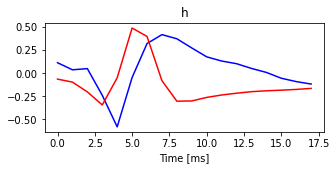

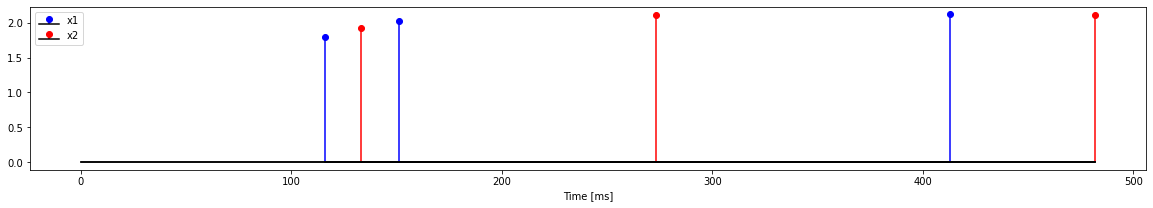

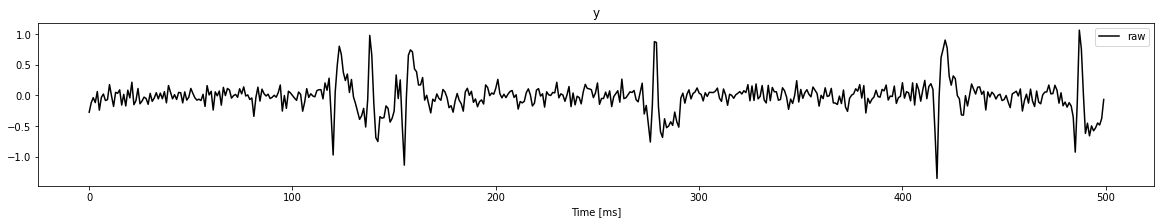

In [ ]:
##########################
####### step 2.7. ########
##### visualize data #####
##########################  
i = 2
yi, xi, h = dataset[i]

# visualize filters
vis_filters(h)

# visualize code for example i
vis_code(xi)

# visualize data
vis_data(yi)

---
## Exercise 3: Train CRsAE 


###3.1. Build CRsAE

Build a neural network suited for your dataset (i.e., learn 2 action potentials, each length 18, unfold the encoder for 200 iterations).

Here, we initialize the weights of the neural network to be perturbed version of the simulated filters (see Eq. (12) in [this paper](https://arxiv.org/abs/1807.04734) for calculation of distance between the dictionaries).


In [ ]:
##########################
######## step 3.1. #######
##### build network ######
##########################  

##########################
####### step 3.1.1 ######
########################## 
# fill in the gaps 
net_hyp = {"T": 200,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 2,                 # number of filters
           "K": 18,                  # legnth of the filters
           "lam": 0.7,
           "device": device
           }
H_init = initialize_filter(dataset.H.clone())
##########################
####### step 3.1.2. ######
##########################  
# create the newtork with hyperparameters define above, and also H=H_init
net = CRsAE1D(net_hyp, H=H_init)

###3.2. Hyperparameters and loader

See how we set training hyperparameters and make the train loader.


In [ ]:
##########################
######## step 3.2. #######
##########################  
# training parameters
train_hyp = {"batch_size": 256, "num_epochs": 20, "lr": 1e-2, "shuffle": True}
# data loader
train_loader = DataLoader(dataset, shuffle=train_hyp["shuffle"], batch_size=train_hyp["batch_size"])

###3.3. Loss function

Specify the loss criterion use for training (i.e., use MSELoss as loss function from torch.nn).


In [ ]:
##########################
######## step 3.3. #######
##########################  
# criterion
criterion = torch.nn.MSELoss()

###3.4. Optimizer

Setup the optimizer (i.e., use ADAM optimizer).

Specify its learning rate (lr), and eps=1e-3, you should set*params=net.parameters()* ( [help](https://pytorch.org/docs/stable/optim.html))


In [ ]:
##########################
######## step 3.4. #######
##########################  
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

###3.5. Train



In [ ]:
##########################
####### step 3.5. ########
######## training ######## 
##########################  

print("\n start training!")
print("initial err_H:{:4f}\n".format(torch.mean(compute_err_h(dataset.H, net.get_param("H")))))
# each loop is one pass over the whole dataset
for epoch in tqdm(range(train_hyp["num_epochs"]), disable=True):
    loss_all = 0
    # each loop is a mini-batch
    for idx, (y,_,_) in tqdm(enumerate(train_loader), disable=False):
        # load data input the device
        y = y.to(device)

        ##########################
        ###### step 3.5.1. #######
        ########################## 
        # run the network in forward net(y) to get y_hat and x_hat
        y_hat, _ = net(y)

        ##########################
        ####### step 3.5.2. ######
        ########################## 
        # compute loss using the created criterion
        loss = criterion(y, y_hat)
        loss_all += float(loss.item())
        
        ##########################
        ####### step 3.5.3 #######
        ########################## 
        # set the gradients in the optimizer to zero (optimizer.zero_grad())
        optimizer.zero_grad()
        # do backward on the loss
        loss.backward()
        # take a step with the optimizer
        optimizer.step()

        # normalize filters
        net.normalize()
        
        err_h = compute_err_h(dataset.H, net.get_param("H"))
    print("Epoch [{}/{}]loss:{:.4f}, err_H:{:4f}\n".format(epoch+1,train_hyp["num_epochs"],loss_all, torch.mean(err_h)))

0it [00:00, ?it/s]


 start training!
initial err_H:0.478045



19it [00:12,  1.47it/s]
0it [00:00, ?it/s]

Epoch [1/20]loss:0.6818, err_H:0.193381



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [2/20]loss:0.4554, err_H:0.053960



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [3/20]loss:0.3366, err_H:0.038078



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [4/20]loss:0.3221, err_H:0.042144



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [5/20]loss:0.3201, err_H:0.047560



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [6/20]loss:0.3197, err_H:0.053210



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [7/20]loss:0.3194, err_H:0.058860



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [8/20]loss:0.3191, err_H:0.064321



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [9/20]loss:0.3188, err_H:0.070529



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [10/20]loss:0.3182, err_H:0.078254



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [11/20]loss:0.3172, err_H:0.090647



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [12/20]loss:0.3133, err_H:0.124675



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [13/20]loss:0.3051, err_H:0.158661



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [14/20]loss:0.3050, err_H:0.152348



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [15/20]loss:0.3048, err_H:0.152004



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [16/20]loss:0.3048, err_H:0.151807



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [17/20]loss:0.3047, err_H:0.151649



19it [00:12,  1.51it/s]
0it [00:00, ?it/s]

Epoch [18/20]loss:0.3048, err_H:0.151346



19it [00:12,  1.50it/s]
0it [00:00, ?it/s]

Epoch [19/20]loss:0.3048, err_H:0.151242



19it [00:12,  1.50it/s]

Epoch [20/20]loss:0.3048, err_H:0.151116



Note: You may learn the filters with a slight shift (either left to right). This results in the shift of the codes to the opposite direction accordingly. Hence, in the reconstruction stage, these shifts will cancel out each other. So, it's fine if your network has learned a shifted version of the simulated filters.

###3.6. Visualize

visualize the learned filters, the reconstructed data, and also reconstruction of each of the neurons separately (i.e, Given the learned filters $\mathbf{h}_1$ and $\mathbf{h}_2$, reconstruction each of neurons can be acquired as following: $\mathbf{H}_1 \mathbf{x}_1$, and $\mathbf{H}_2 \mathbf{x}_2$). Look into **separate** function in CRsAE1D for detailed implementation of this separation.

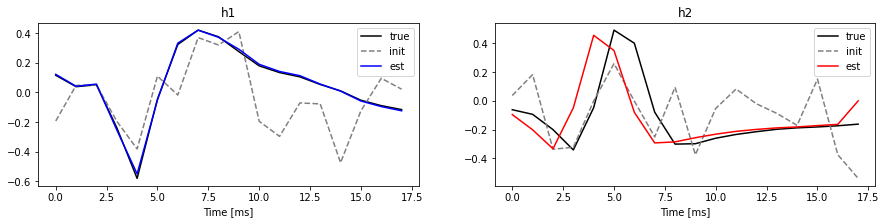

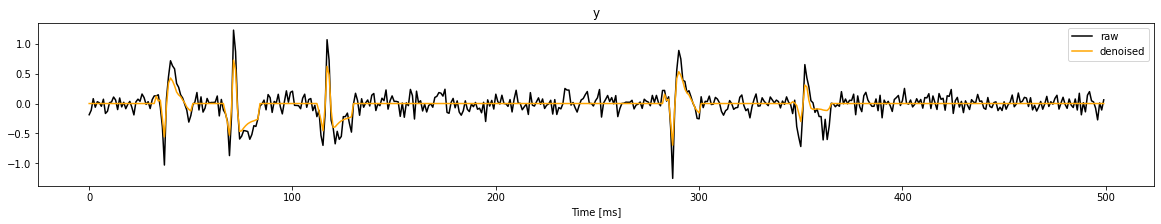

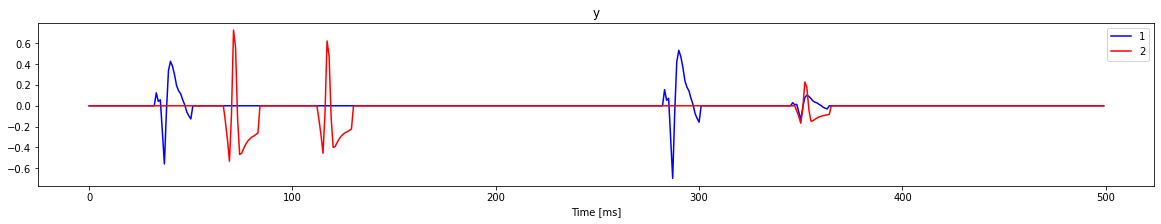

In [ ]:
##########################
####### step 3.6. ########
########################## 
yi, xi, _ = dataset[0:3]
yi_hat, xi_hat = net(yi)

# this function gets y and gives [h1 * x1, h2 * x2]
hx = net.separate(yi)

# visualize the filters
vis_filter_est(dataset.H, H_init, net.get_param("H"))

# visualize the data
vis_data_est(yi[0], yi_hat[0])

# visualize Hx1 and Hx2
vis_data_separated_est(hx[0][0], hx[0][1])

---
## Exercise 4: Spike Sorting on Harris Dataset





###4.1. Load Harris dataset

The **harris_dataset** dataset contains y_series_harris with dim (1, 1, 1492000) and y_harris with dim (24,1,60000).

1492000 is the length of the whole dataset. y_harris is windowed version of y_series_harris (24 * 60000 ~= 1492000).

In y_harris, some portion of the data containing bursting is removed for the purpose of training.

In this dataset, there seems to be mainly two neurons active.

In [ ]:
##########################
####### step 4.1. ########
###### load dataset ######
##########################  

# load dataset
# y_harris has dimension  (24, 1, 60000)
y_harris = load_y_harris(device)                    
y_series_harris = load_y_series_harris(device)

class HarrisDataset(Dataset):
    def __init__(self, y, y_series, device):

        self.device = device
        self.J = y.shape[0]
        self.y = y.to(self.device)
        self.y_series = y_series.to(self.device)
        
    def __len__(self):
        return self.J

    def __getitem__(self, idx):
        return self.y[idx], self.y_series[0]

harris_dataset = HarrisDataset(y_harris, y_series_harris, device)

print("y_harris shape:", y_harris.shape)
print("y_series_harris shape:", y_series_harris.shape)

y_harris shape: torch.Size([24, 1, 60000])
y_series_harris shape: torch.Size([1, 1, 1, 1492000])


###4.2. Hyperparamaters and initialization

Set the hypeparameters (i.e., learn 2 action potentials, each length 35, unfold the encoder for 600 iterations, batch size of 1).

Create dataloader for the dataset (i.e., use shuffle and batch size from the hyperparameters, and the created dataset in previous step), and load initialized filters (i.e., the filters are two action potentials picked from the dataset using k-means).

In [ ]:
##########################
######## step 4.2.########
#### hyperparameters #####
##########################  

# parameters
harris_hyp = {"J": 24,            # number of windows
              "T": 600,           # number of encoder unfolding
              "L": 15,            # 1/L is the encoder step size
              "C": 2,             # number of filters
              "K": 35,            # length of filters
              "lam": 0.25,        # lambda (enforcing sparsity)
              "device": device,
              "batch_size": 1,    # number of examples in each gradient update
              "num_epochs": 20,
              "lr": 5e-3,
              "shuffle": True}

# load init filters
h_init = load_h_init_harris(device)

# data loader
train_loader = DataLoader(harris_dataset, shuffle=harris_hyp["shuffle"], batch_size=harris_hyp["batch_size"])


###4.3. Build CRsAE

Build CRsAE, a neural network suited for the Harris dataset using the hyperparameters and the loaded filters.

In [ ]:
##########################
######## step 4.3. #######
##### build network ######
##########################  

# build network
harris_net = CRsAE1D(harris_hyp, H=h_init)

###4.4. Loss and optimizer

Specify the loss criterion use for training (i.e., use MSELoss as loss function from torch.nn) and setup the optimizer (i.e., use ADAM optimizer). Specify its learning rate (lr), and eps=1e-3, you should set*params=net.parameters()* ( [help](https://pytorch.org/docs/stable/optim.html))

In [ ]:
##########################
######## step 4.4. #######
##### loss and optim #####
##########################  


# use mse loss as criterion
criterion = torch.nn.MSELoss()

# build optimizer
optimizer = optim.Adam(harris_net.parameters(), lr=harris_hyp["lr"], eps=1e-3)

### 4.5. Train

In [ ]:
##########################
######## step 4.5.########
######### train! #########
##########################  

print("\n start training!")
print("initial err_H:{:4f}\n".format(torch.mean(compute_err_h(h_init, harris_net.get_param("H")))))
for epoch in tqdm(range(harris_hyp["num_epochs"]), disable=True):
    loss_all = 0
    for idx, (y,_) in tqdm(enumerate(train_loader), disable=False):
        # load data input the device
        y = y.to(device)

        # forward
        y_hat, _ = harris_net(y)

        # compute loss
        loss = criterion(y, y_hat)
        loss_all += float(loss.item())
        

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # normalize filters
        harris_net.normalize()
        
        err_h = compute_err_h(h_init, harris_net.get_param("H"))
    print("Epoch [{}/{}]loss:{:.4f}, err_H:{:4f}\n".format(epoch+1,harris_hyp["num_epochs"],loss_all, torch.mean(err_h)))

0it [00:00, ?it/s]


 start training!
initial err_H:0.000000



24it [00:27,  1.13s/it]
0it [00:00, ?it/s]

Epoch [1/20]loss:0.0899, err_H:0.000529



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [2/20]loss:0.0897, err_H:0.000576



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [3/20]loss:0.0896, err_H:0.001261



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [4/20]loss:0.0895, err_H:0.002122



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [5/20]loss:0.0894, err_H:0.003089



24it [00:27,  1.14s/it]
0it [00:00, ?it/s]

Epoch [6/20]loss:0.0893, err_H:0.004095



24it [00:27,  1.13s/it]
0it [00:00, ?it/s]

Epoch [7/20]loss:0.0892, err_H:0.005166



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [8/20]loss:0.0892, err_H:0.006270



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [9/20]loss:0.0891, err_H:0.007535



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [10/20]loss:0.0891, err_H:0.008771



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [11/20]loss:0.0891, err_H:0.009999



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [12/20]loss:0.0890, err_H:0.011200



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [13/20]loss:0.0890, err_H:0.012404



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [14/20]loss:0.0890, err_H:0.013573



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [15/20]loss:0.0890, err_H:0.014684



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [16/20]loss:0.0889, err_H:0.015749



24it [00:26,  1.12s/it]
0it [00:00, ?it/s]

Epoch [17/20]loss:0.0889, err_H:0.016865



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [18/20]loss:0.0889, err_H:0.017974



24it [00:26,  1.11s/it]
0it [00:00, ?it/s]

Epoch [19/20]loss:0.0889, err_H:0.018964



24it [00:26,  1.12s/it]

Epoch [20/20]loss:0.0889, err_H:0.019960



### 4.6. Visualize

Visualize the learned filters, the reconstructed data, and also reconstruction of each of the neurons separately (i.e, Given the learned filters $\mathbf{h}_1$ and $\mathbf{h}_2$, reconstruction each of neurons can be acquired as following: $\mathbf{H}_1 \mathbf{x}_1$, and $\mathbf{H}_2 \mathbf{x}_2$).

Look into **separate** function in CRsAE1D for detailed implementation of this separation.

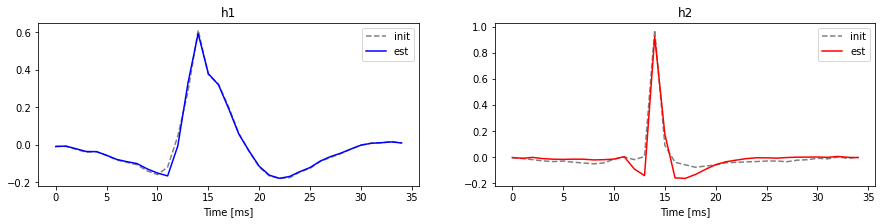

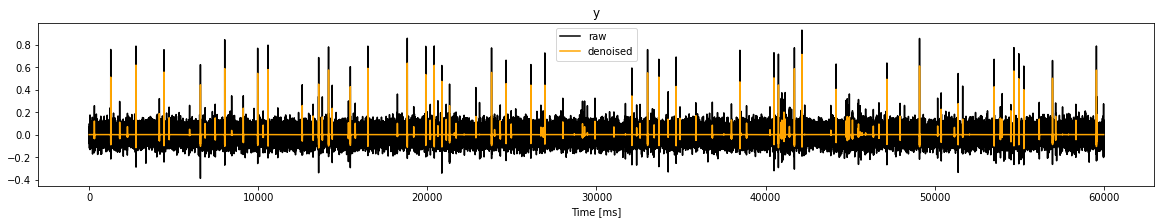

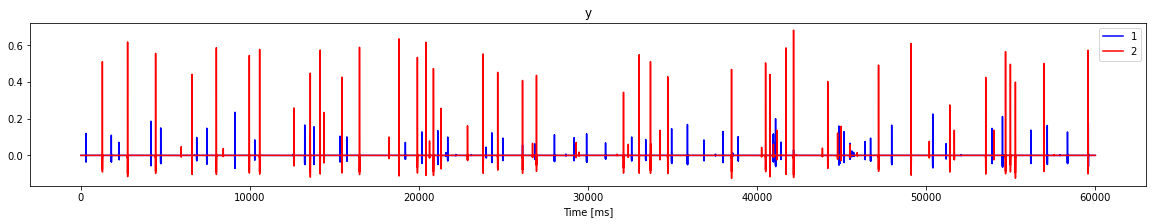

In [ ]:
##########################
######## step 4.6. #######
######## visualize #######
##########################  

yi, y_series = harris_dataset[0:4]

# run netowrk for yi
yi_hat, xi_hat = harris_net(yi)

# get [h1 * x1, h2 * x2] from yi
hx = harris_net.separate(yi)

# visualize the filters (action potentials)
vis_filter_est(None, h_init, harris_net.get_param("H"))

# visualize the raw and denoised
vis_data_est(yi[0], yi_hat[0])

# visualize the separated activities
vis_data_separated_est(hx[0][0], hx[0][1])

###4.7. Perform spike sorting

For more info read VII. Experiments, B. Spike Sorting: Real Data. subsection Spike Sorting from [paper](https://arxiv.org/abs/1904.08827)).

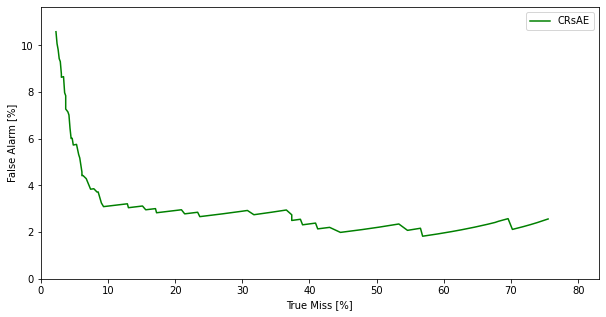

In [ ]:
##########################
######### step 7 #########
##### spike sorting ######
##########################  

def miss_false_spikes(spikes, spikes_hat, event_range):
    """
    function to calculate miss and false spikes
    :param spikes: true spikes (from intracellular)
    :param spikes_hat: estimated spikes
    :param event_range: range of which spikes match with each other
    :return: (missed_spikes, missed_per, false_spikes, false_per)
    """

    ctr_true_event = 0
    ctr_pred_event = 0

    missed_spikes = 0
    false_spikes = 0

    # loop over true spikes
    for k in range(len(spikes)):
        ctr_true_event += 1
        event_distance = spikes[k] - spikes_hat
        close_event = event_distance[np.where(event_distance[event_distance>=0] < event_range)]
        if len(close_event) == 0:
            missed_spikes += 1
    # loop over predicted spikes
    for k in range(len(spikes_hat)):
        ctr_pred_event += 1
        event_distance = spikes - spikes_hat[k]
        close_event = event_distance[np.where(event_distance[event_distance>=0] < event_range)]
        if len(close_event) == 0:
            false_spikes += 1

    if ctr_true_event != 0:
        missed_per = (missed_spikes / ctr_true_event) * 100
    if ctr_pred_event != 0:
        false_per = (false_spikes / ctr_pred_event) * 100

    return missed_spikes, missed_per, false_spikes, false_per


##########################
######## step 6.1 ########
########################## 
# use the seaprate function and use y_series is input. 
hx_series = harris_net.separate(y_series)

# load the spikes from intracellular recordings from neurons with index 0
spikes = np.load("spikes.npy")

# get hx1 from hx_series
hx1 = hx_series[0,0,:].clone().detach().cpu().numpy()

# create a list of thresholds
th_list = np.double(np.arange(0.1*np.max(hx1), 0.5*np.max(hx1), 0.001))

missed_per_list = []
false_per_list = []
for th in th_list:
  ##########################
  ######## step 6.2 ########
  ########################## 
  # find indices of peaks from hx1, using height=th
  spikes_hat = find_peaks(hx1, height=th)[0]

  ##########################
  ######## step 6.3 ########
  ########################## 
  # compute missed true and false alaram using the function miss_false_spikes
  # use the following event_rage in the function
  event_range = 5
  missed_spikes, missed_per, false_spikes, false_per = miss_false_spikes(
      spikes, spikes_hat, event_range
  )

  missed_per_list.append(missed_per)
  false_per_list.append(false_per)

# plot true miss - false alarm
vis_miss_false(missed_per_list, false_per_list)

Ideally, you want the above curve to be all the way down and left (the least false alarm and the true miss).

---
## Wrap-up

In this notebook, we learn about a convolutional generative model and how we can learn the parameters of the model through a particular recurrent neural network called CRsAE. We learned how to build and train CRsAE. We visualized the weights (filters). For our specific problem, the filters were corresponding to the shape of action potentials each neuron exhibits. At last, We applied CRsAE to Harris dataset and performed spike sorting.